In [ ]:
 !mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq utkface-new.zip

replace UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


In [ ]:
!pip install wandb

In [5]:
import wandb

from wandb.keras import(
    WandbMetricsLogger,
    WandbModelCheckpoint,
)

In [6]:
run = wandb.init(project='Age_Prediction')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
config = wandb.config

In [8]:
wandb_callbacks = [
     WandbMetricsLogger(log_freq=5),
     WandbModelCheckpoint("models")
]

In [9]:
width = height = 100

In [10]:
images = []  # x
ages = []  # Y

for image_name in os.listdir('UTKFace'):
    parts = image_name.split("_")
    age = int(parts[0])
    ages.append(age)

    image = cv2.imread('UTKFace/' + image_name)
    image = cv2.resize(image, (width, height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)


In [11]:
images = pd.Series(images, name="Images")
ages = pd.Series(ages, name="Ages")
df = pd.concat([images, ages], axis=1)
df.head()

,Images,Ages
0,"[[[189, 174, 177], [189, 175, 175], [193, 177,...",60
1,"[[[127, 84, 54], [136, 96, 63], [130, 93, 56],...",12
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8
3,"[[[220, 211, 72], [228, 221, 79], [221, 214, 7...",9
4,"[[[50, 27, 19], [44, 21, 15], [49, 24, 20], [5...",21


30


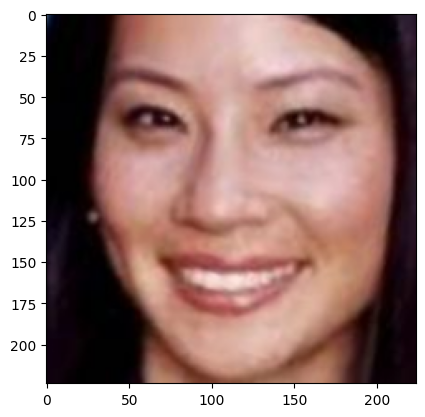

In [ ]:
print(df['Ages'][58])
plt.imshow(df['Images'][58])
plt.show()

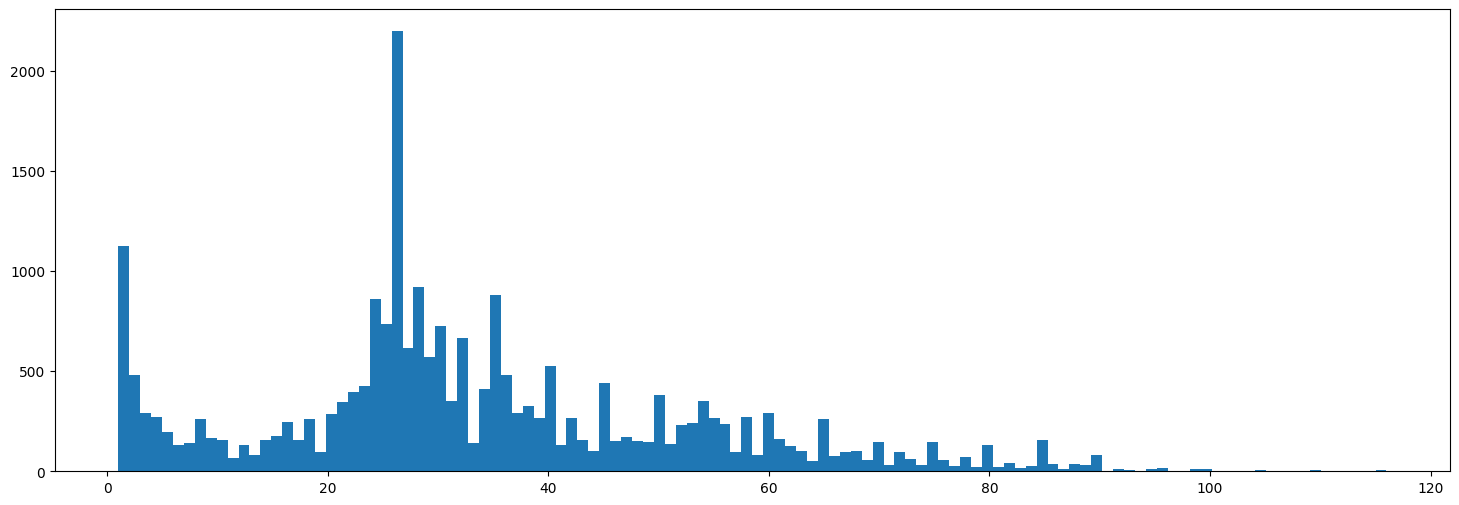

In [ ]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=df['Ages'].max())  #به تعداد سن افراد ستون رسم کن
plt.show()

In [12]:
age26_1 = df[(df['Ages'] == 26) | (df['Ages'] == 1)]
age_not26_1 = df[(df['Ages'] != 26) | (df['Ages'] != 1)]

age26_1 = age26_1.sample(frac=0.3)
df = pd.concat([age26_1, age_not26_1], axis=0)

In [13]:
df = df[df['Ages'] < 80]

In [14]:
del images
del ages
del age26_1
del age_not26_1

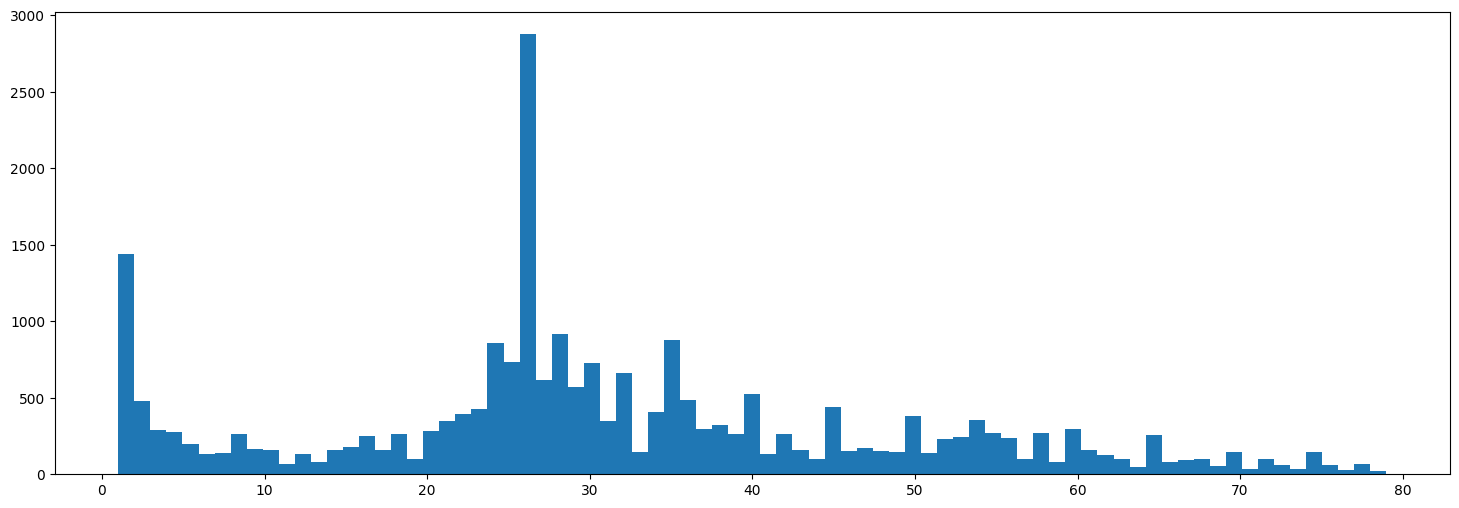

In [15]:
plt.figure(figsize=(18, 6))
plt.hist(df['Ages'], bins=df['Ages'].max())  #به تعداد سن افراد ستون رسم کن
plt.show()

In [16]:
X = np.array(df['Images'].values.tolist()) #تبدیل از پانداز به نامپای ارری
Y = np.array(df['Ages'].values.tolist())

In [17]:
del df

In [18]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

In [19]:
del X
del Y

In [20]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

train_data = image_data_generator.flow(
    X_train,
    Y_train,
    batch_size=32,
    shuffle=True
)

validation_data = image_data_generator.flow(
    X_validation,
    Y_validation,
    batch_size=32,
    shuffle=True
)

In [21]:
del X_train
del X_validation
del Y_train
del Y_validation

In [22]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,  #لایه های دنس  را حذف میکند
    weights='imagenet',  #Transfer Learning
    input_shape=(width, height, 3),
    pooling='avg'
)

94668760/94668760 [==============================] - 0s 0us/step


In [23]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [24]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='relu')  #چون مساله رگرشن هست لایه های آخر یک است
])

In [25]:
model.compile(
    loss=tf.keras.losses.mean_absolute_error,
    optimizer=tf.keras.optimizers.Adam(),
    # metrics='accuracy'  #چون مساله رگرشن هست نیاز به اکیورسی نداریم
)

In [26]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    callbacks=wandb_callbacks
)

Epoch 1/20
600/601 [============================>.] - ETA: 0s - loss: 13.4115

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 62s 79ms/step - loss: 13.4021 - val_loss: 10.0451
Epoch 2/20
601/601 [==============================] - ETA: 0s - loss: 9.8798

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 45s 75ms/step - loss: 9.8798 - val_loss: 9.1774
Epoch 3/20
600/601 [============================>.] - ETA: 0s - loss: 9.4093

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 44s 73ms/step - loss: 9.4094 - val_loss: 8.8413
Epoch 4/20
601/601 [==============================] - ETA: 0s - loss: 9.1745

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 44s 74ms/step - loss: 9.1745 - val_loss: 8.6317
Epoch 5/20
601/601 [==============================] - ETA: 0s - loss: 9.0684

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 45s 75ms/step - loss: 9.0684 - val_loss: 8.4726
Epoch 6/20
601/601 [==============================] - ETA: 0s - loss: 8.9866

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 44s 73ms/step - loss: 8.9866 - val_loss: 8.4506
Epoch 7/20
600/601 [============================>.] - ETA: 0s - loss: 8.8910

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 44s 73ms/step - loss: 8.8942 - val_loss: 8.3739
Epoch 8/20
600/601 [============================>.] - ETA: 0s - loss: 8.9246

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 46s 76ms/step - loss: 8.9240 - val_loss: 8.3204
Epoch 9/20
600/601 [============================>.] - ETA: 0s - loss: 8.9034

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 44s 74ms/step - loss: 8.9027 - val_loss: 8.3212
Epoch 10/20
601/601 [==============================] - ETA: 0s - loss: 8.8993

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 44s 73ms/step - loss: 8.8993 - val_loss: 8.2700
Epoch 11/20
600/601 [============================>.] - ETA: 0s - loss: 8.8642

wandb: Adding directory to artifact (./models)... Done. 0.4s


601/601 [==============================] - 47s 78ms/step - loss: 8.8675 - val_loss: 8.2371
Epoch 12/20
600/601 [============================>.] - ETA: 0s - loss: 8.9229

wandb: Adding directory to artifact (./models)... Done. 0.4s


601/601 [==============================] - 46s 76ms/step - loss: 8.9189 - val_loss: 8.2076
Epoch 13/20
601/601 [==============================] - ETA: 0s - loss: 8.8436

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 49s 81ms/step - loss: 8.8436 - val_loss: 8.2115
Epoch 14/20
600/601 [============================>.] - ETA: 0s - loss: 8.8516

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 47s 78ms/step - loss: 8.8515 - val_loss: 8.2560
Epoch 15/20
601/601 [==============================] - ETA: 0s - loss: 8.8075

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 44s 74ms/step - loss: 8.8075 - val_loss: 8.1734
Epoch 16/20
601/601 [==============================] - ETA: 0s - loss: 8.7870

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 45s 75ms/step - loss: 8.7870 - val_loss: 8.1237
Epoch 17/20
600/601 [============================>.] - ETA: 0s - loss: 8.8188

wandb: Adding directory to artifact (./models)... Done. 0.4s


601/601 [==============================] - 44s 74ms/step - loss: 8.8224 - val_loss: 8.1024
Epoch 18/20
600/601 [============================>.] - ETA: 0s - loss: 8.7815

wandb: Adding directory to artifact (./models)... Done. 0.4s


601/601 [==============================] - 45s 75ms/step - loss: 8.7821 - val_loss: 8.1813
Epoch 19/20
601/601 [==============================] - ETA: 0s - loss: 8.7293

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 44s 74ms/step - loss: 8.7293 - val_loss: 8.1488
Epoch 20/20
601/601 [==============================] - ETA: 0s - loss: 8.7723

wandb: Adding directory to artifact (./models)... Done. 0.3s


601/601 [==============================] - 44s 73ms/step - loss: 8.7723 - val_loss: 8.1153


In [27]:
model.save('/content/drive/MyDrive/Saved_Models/age_prediction_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
